In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:

# Define the preprocessing function
def preprocess(text):

    # Remove punctuation and lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Tokenize text using NLTK library
    tokens = word_tokenize(text)

    # Stem tokens using Porter Stemmer
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in stemmed_tokens if token not in stop_words]

    # Join filtered tokens into a string
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

In [3]:
# Define the function for spell checking

def edit_distance_similarity(str1, str2):
    m = len(str1)
    n = len(str2)
    table = [[None] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                table[i][j] = 0
            elif str1[i - 1] == str2[j - 1]:
                table[i][j] = table[i - 1][j - 1] + 1
            else:
                table[i][j] = max(table[i - 1][j], table[i][j - 1])
    lcs = ""
    i, j = m, n
    while i > 0 and j > 0:
        if str1[i - 1] == str2[j - 1]:
            lcs = str1[i - 1] + lcs
            i -= 1
            j -= 1
        elif table[i - 1][j] > table[i][j - 1]:
            i -= 1
        else:
            j -= 1

    return max(len(str1),len(str2)) - len(lcs)


def jaccard_similarity(s1, s2):
    bigrams1 = set([s1[i:i+2] for i in range(len(s1)-1)])
    bigrams2 = set([s2[i:i+2] for i in range(len(s2)-1)])

    # calculate intersection and union of bigram sets
    intersection = len(bigrams1.intersection(bigrams2))
    union = len(bigrams1.union(bigrams2))

    # calculate Jaccard coefficient
    jaccard_coeff = intersection / union

    return jaccard_coeff

In [4]:
# Define the information retrieval system class
class InformationRetrievalSystem:

   # Making inverted index
    def __init__(self, documents):
        self.documents = documents
        self.top_k_results = 25
        self.inverted_index = defaultdict(list)
        k = None

        for i, document in enumerate(documents):
            preprocessed_document = preprocess(document)
            tokens = preprocessed_document.split()
            for token in tokens:
              self.inverted_index[token].append(i)


    # Spell checking and correction
    def spell_check(self, query):
        candidates = set()
        query = preprocess(query)
        print("User Query : ",query)
        spell_checked_query = query

        for document_idx in range(0,len(self.documents)):
            document = self.documents[document_idx]
            document_tokens = preprocess(document).split()
            for document_token in document_tokens:
              candidates.add(document_token)

        optimal_replace = dict()

        for token in query.split():
            for document_token in candidates:
                similarity_value = edit_distance_similarity(token, document_token)
                # print(token,document_token,similarity_value)
                edit_distance_limit = 2

                if similarity_value <= edit_distance_limit:
                    if optimal_replace.get(token)==None:
                      optimal_replace[token] = (similarity_value, document_token)
                    else:
                      if similarity_value < optimal_replace[token][0]:
                        optimal_replace[token] = (similarity_value,document_token)

        for key, value in optimal_replace.items():
          spell_checked_query = spell_checked_query.replace(key, value[1])

        print("Query after Spell checking : ",spell_checked_query)
        return spell_checked_query

    # Finding Tf-idf of query tokens
    def vectorize(self, query):
        vector = np.zeros(len(self.documents))
        query = preprocess(query)
        query_tokens = query.split()
        for query_token in query_tokens:
            for document_idx in self.inverted_index[query_token]:
                document = self.documents[document_idx]
                document_tokens = preprocess(document).split()
                tf = document_tokens.count(query_token)
                idf = np.log(len(self.documents) / len(self.inverted_index[query_token]))
                vector[document_idx] += tf * idf
        return vector



    # Retrieving top K results using cosine similarity (Vector Space Model)
    def retrieve(self, query):
        doc_score_list = []
        num_results = self.top_k_results
        spell_checked_query = self.spell_check(query)
        vector = self.vectorize(spell_checked_query)
        for i in range(0,len(documents)):
            vector_doc = self.vectorize(self.documents[i])
            scores = np.dot(vector/np.linalg.norm(vector), vector_doc/np.linalg.norm(vector_doc))
            doc_score_list.append(scores)
        sorted_indices = np.argsort(doc_score_list)[::-1][:num_results]
        print("Top ",num_results," documents ID & their Cosine similarity: ")
        for i in range(0,num_results):
          print("(",sorted_indices[i],",",doc_score_list[sorted_indices[i]],")")
        print("\n")
        return [self.documents[i] for i in sorted_indices],sorted_indices


    def boolean_retrivel(self,query):
        spell_checked_query = self.spell_check(query)
        query = spell_checked_query.replace(" ", " AND ")
        result = set(range(len(documents)))
        for term in query.split():
            if term == "AND":
                continue
            elif term == "OR":
                continue
            elif term == "NOT":
                continue
            elif term in self.inverted_index:
                if query.startswith("NOT"):
                    result.difference_update(self.inverted_index[term])
                else:
                    result.intersection_update(self.inverted_index[term])
        return list(result)




In [5]:

documents = [
"Marathon Training for Beginners: 16-Week Training Plan",
"How to run a marathon",
"10 Tips for Successfully Training for a Marathon",
"How to Train for a Marathon: A Complete Guide",
"Marathon Training Schedule: 20-Week Plan",
"Marathon Training: 5 Key Tips",
"The Mental Side of Marathon Training",
"Marathon Training Nutrition: What to Eat Before, During, and After Your Run",
"The Benefits of Cross-Training for Marathon Runners",
"Marathon Training: Common Mistakes and How to Avoid Them",
"How to Train for Your First Marathon",
"Marathon Training: How to Increase Your Mileage Safely",
"Marathon Training: The Importance of Rest and Recovery",
"How to Train for a Marathon in 3 Months",
"Marathon Training: Strength Training for Runners",
"How to Train for a Marathon: The Beginner's Guide",
"The Importance of Stretching in Marathon Training",
"How to Train for a Marathon: Tips from Elite Runners",
"Marathon Training: Dealing with Injury and Setbacks",
"Marathon Training: The Best Apps and Tools to Help You Succeed",
"How to Run Your First Marathon: Tips from Experienced Runners",
"How to Build Mental Toughness for Marathon Training",
"How to Run a Faster Marathon: Tips from Professional Runners",
"How to Stay Motivated During Marathon Training",
"How to Run a Marathon without Getting Injured",
"How to Run a Marathon on a Budget: Tips and Tricks",
"10 Foods to Fuel Your Marathon Training",
"Marathon Running: History and Evolution",
"The Benefits of Yoga for Runners",
"The Science of Running: Understanding Your Body's Performance",
"10 Reasons to Start Running Today",
"The Best Running Shoes for Women",
"The Benefits of Meditation for Runners",
"How to Run a 5K: Training Tips and Tricks",
"The Top 10 Marathons in the World",
"Running for Weight Loss: Tips and Strategies",
"The Pros and Cons of Running on a Treadmill",
"The Best Running Watches for Tracking Your Progress",
"How to Avoid Common Running Injuries",
"The Best Running Apps for Your Smartphone",
"The Benefits of Running for Your Mental Health",
"The History of the Marathon: From Ancient Greece to Modern Times",
"The Best Running Routes in Your City",
"The Benefits of Trail Running: Getting Back to Nature",
"The Top 10 Running Tips for Beginners",
"The Best Running Clothes for Every Season",
"The Importance of Hydration for Runners",
"How to Run Your First 10K: Training and Nutrition Tips",
"The Benefits of Running for Your Cardiovascular Health",
"The Science of Endurance: What Happens to Your Body During a Marathon",
"The Best Running Apps for Music Lovers",
"The Benefits of Running for Your Immune System",
"The Pros and Cons of Running Alone vs. Running with a Group",
"How to Start Running: A Beginner's Guide",
"The Best Running Blogs for Inspiration and Motivation",
"The Benefits of Running for Your Bone Health",
"The Top 10 Running Events in Your Area",
"The Benefits of High-Intensity Interval Training (HIIT) for Runners",
"The Best Running Podcasts for Your Commute",
"The Benefits of Running for Your Joint Health",
"The Pros and Cons of Running on Different Surfaces",
"The Benefits of Running for Your Digestive Health",
"The Top 10 Running Shoes for Men",
"The Benefits of Running for Your Brain Health",
"How to Run Your First Half Marathon: Training and Nutrition Tips",
"The Best Running Gear for Your Next Race",
"The Benefits of Running for Your Skin Health",
"The Pros and Cons of Running in the Morning vs. the Evening",
"The Benefits of Running for Your Sleep Quality",
"The Top 10 Running Books for Your Reading List",
"The Benefits of Running for Your Stress Levels",
"The Best Running Apps for Tracking Your Nutrition",
"The Benefits of Running for Your Social Life",
"The Pros and Cons of Running with a Pet",

]
documents_two =  [
"Sustainable Agriculture Techniques for Small-Scale Farmers: A Practical Guide",
"The Benefits of Cover Cropping in Small-Scale Agriculture",
"Crop Rotation Techniques for Sustainable Small-Scale Agriculture",
"The Importance of Soil Health in Small-Scale Agriculture",
"The Role of Composting in Sustainable Small-Scale Agriculture",
"The Benefits of Agroforestry for Small-Scale Farmers",
"Integrated Pest Management Techniques for Sustainable Small-Scale Agriculture",
"The Benefits of Water Conservation for Small-Scale Agriculture",
"The Importance of Biodiversity in Small-Scale Agriculture",
"The Role of Livestock in Sustainable Small-Scale Agriculture",
"The Benefits of Using Native Plants in Small-Scale Agriculture",
"The Importance of Seed Saving in Small-Scale Agriculture",
"The Role of Agroecology in Sustainable Small-Scale Agriculture",
"The Benefits of Using Green Manure in Small-Scale Agriculture",
"The Importance of Crop Diversity in Small-Scale Agriculture",
"The Role of Microorganisms in Sustainable Small-Scale Agriculture",
"The Benefits of Drip Irrigation for Small-Scale Agriculture",
"The Importance of Community-Based Agriculture for Small-Scale Farmers",
"The Role of Women in Sustainable Small-Scale Agriculture",
"The Benefits of Using Natural Fertilizers in Small-Scale Agriculture",
"The Importance of Crop Planning in Small-Scale Agriculture",
"The Role of Agroforestry in Soil Conservation for Small-Scale Farmers",
"The Benefits of Using Solar Energy in Small-Scale Agriculture",
"The Importance of Organic Farming for Sustainable Small-Scale Agriculture",
"The Role of Farm Cooperatives in Sustainable Small-Scale Agriculture",
"The History of Agriculture in the United States",
"How to Start a Large-Scale Farm",
"The Benefits of GMO Crops for Commercial Agriculture",
"The Future of Agriculture: Technology and Innovation",
"The Negative Impact of Pesticides on the Environment",
"The Advantages of Vertical Farming for Urban Agriculture",
"The Impact of Climate Change on Agriculture",
"The Benefits of Organic vs Conventional Farming",
"The Role of Agriculture in Economic Development",
"The Benefits of Hydroponic Farming for Urban Agriculture",
"The Pros and Cons of Factory Farming",
"The Importance of Agriculture Education for the Future",
"The Impact of Agriculture on Wildlife and Biodiversity",
"The Benefits of Agriculture as a Career Path",
"The Role of Agricultural Policies in Developing Countries",
"The Impact of Land Use Change on Agriculture",
"The Advantages and Disadvantages of Precision Agriculture",
"The Importance of Agricultural Research and Development",
"The Benefits of Using Artificial Intelligence in Agriculture",
"The Impact of Agriculture on Water Quality",
"The Role of Agricultural Trade in the Global Economy",
"The Benefits of Using Biotechnology in Agriculture",
"The Impact of Agriculture on Climate Change Mitigation",
"The Pros and Cons of Organic vs Conventional Agriculture",
"The Importance of Agriculture Extension Services for Small-Scale Farmers",
"The Role of Agricultural Cooperatives in Rural Development",
"The Benefits of Using Renewable Energy in Agriculture",
"The Impact of Agricultural Practices on Soil Erosion",
"The Importance of Agricultural Diversity for Food Security",
"The Role of Agricultural Insurance in Managing Risk for Small-Scale Farmers",
"The Benefits of Crop Insurance for Small-Scale Farmers",
"The Impact of Agricultural Policies on Food Prices",
"The Pros and Cons of Agricultural Subsidies",
"The Importance of Agricultural Marketing for Small-Scale Farmers",
"The Role of Agriculture in Sustainable Development Goals",
"The Benefits of Precision Livestock Farming for Animal Welfare",
"The Impact of Climate Change on Agricultural Production",
"The Importance of Agricultural Education for Rural Development",
"The Role of Agriculture in Economic Growth and Poverty Reduction",
"The Pros and Cons of Genetically Modified Crops in Agriculture",
"The Impact of Agricultural Practices on Biodiversity",
"The Benefits of Agroforestry for Sustainable Agriculture",
"The Importance of Soil Health for Agricultural Productivity",
"The Role of Agricultural Research Institutions in Innovation for Small-Scale Farmers",
"The Impact of Agricultural Practices on Greenhouse Gas Emissions",
"The Pros and Cons of Agricultural Biotechnology",
"The Benefits of Diversified Farming Systems for Sustainable Agriculture",
"The Importance of Gender Equality in Agricultural Development",
"The Role of Agricultural Extension Services in Climate-Smart Agriculture",
"The Impact of Agricultural Practices on Water Use Efficiency",
]
top_k_result = 25
ir_system = InformationRetrievalSystem(documents)
query = "How to Train for a Marathon"
results,retrieved_results = ir_system.retrieve(query)
print("Retrieved Documents : ")
print("\n".join(results))

print("\nBoolean Retrieved Documents :")
boolean_results = ir_system.boolean_retrivel(query)
print(boolean_results)


User Query :  train marathon
Query after Spell checking :  train marathon
Top  25  documents ID & their Cosine similarity: 
( 14 , 0.9318161869252585 )
( 10 , 0.9129934121192308 )
( 0 , 0.8935389810851364 )
( 6 , 0.8338045758223838 )
( 3 , 0.8338045758223838 )
( 16 , 0.8338045758223837 )
( 13 , 0.8299146252078834 )
( 15 , 0.8218222865226702 )
( 17 , 0.806508812280081 )
( 2 , 0.7848652363734681 )
( 5 , 0.7836024982604498 )
( 4 , 0.7707872849393446 )
( 23 , 0.7476616734940441 )
( 26 , 0.7451474395361262 )
( 21 , 0.7408207790264039 )
( 12 , 0.7408207790264039 )
( 18 , 0.7245187454225249 )
( 11 , 0.7232777681098391 )
( 1 , 0.709486073701762 )
( 64 , 0.702813229063815 )
( 9 , 0.6975368447848859 )
( 7 , 0.6829157887136575 )
( 33 , 0.6135426074800464 )
( 47 , 0.5889434719735069 )
( 19 , 0.5765053924740375 )


Retrieved Documents : 
Marathon Training: Strength Training for Runners
How to Train for Your First Marathon
Marathon Training for Beginners: 16-Week Training Plan
The Mental Side of Mar

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_f1_score_at_k(retrieved_docs, relevant_docs, k):
    num_retrieved = len(retrieved_docs[:k])
    num_relevant = len(relevant_docs)

    # Compute the number of retrieved relevant documents
    num_retrieved_relevant = len(set(retrieved_docs[:k]).intersection(set(relevant_docs)))

    # Compute the precision and recall scores at k
    precision = num_retrieved_relevant / num_retrieved if num_retrieved > 0 else 0
    recall = num_retrieved_relevant / num_relevant if num_relevant > 0 else 0

    # Compute the F1-score at k
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1_score

def generate_f1_score_curve(retrieved_docs_list, relevant_docs_list):
    num_queries = len(retrieved_docs_list)

    # Compute the F1-scores for each query at different values of k
    k_values = np.arange(1, 26) # Consider top 1 to 10 retrieved documents
    f1_scores = np.zeros((num_queries, len(k_values)))
    for i in range(num_queries):
        for j, k in enumerate(k_values):
            f1_score = evaluate_f1_score_at_k(retrieved_docs_list[i], relevant_docs_list[i], k)
            f1_scores[i, j] = f1_score

    # Compute the mean F1-scores across queries at each value of k
    mean_f1_scores = np.mean(f1_scores, axis=0)

    # Generate the F1-score curve
    plt.plot(k_values, mean_f1_scores, 'r-', label='F1-score')
    plt.xlabel('Number of retrieved documents')
    plt.ylabel('F1-score')
    plt.title('F1-score Curve')
    plt.ylim([0, 1])
    plt.xlim([1, 25])
    plt.legend(loc='best')
    plt.show()



In [7]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_precision_at_k(retrieved_docs, relevant_docs, k):
    num_retrieved = len(retrieved_docs[:k])
    num_relevant = len(relevant_docs)

    # Compute the number of retrieved relevant documents
    num_retrieved_relevant = len(set(retrieved_docs[:k]).intersection(set(relevant_docs)))

    # Compute the precision score at k
    precision = num_retrieved_relevant / k if k > 0 else 0

    return precision
def evaluate_recall_at_k(retrieved_docs, relevant_docs, k):
    num_retrieved = len(retrieved_docs[:k])
    num_relevant = len(relevant_docs)

    # Compute the number of retrieved relevant documents
    num_retrieved_relevant = len(set(retrieved_docs[:k]).intersection(set(relevant_docs)))

    # Compute the recall score at k
    recall = num_retrieved_relevant / num_relevant if num_relevant > 0 else 0

    return recall

def generate_mix(retrieved_docs_list, relevant_docs_list):
    num_queries = len(retrieved_docs_list)

    # Compute the precision scores for each query at different values of k
    k_values = np.arange(1, 26) # Consider top 1 to 10 retrieved documents
    precision_scores = np.zeros((num_queries, len(k_values)))
    recall_scores = np.zeros((num_queries, len(k_values)))
    for i in range(num_queries):
        for j, k in enumerate(k_values):
            precision = evaluate_precision_at_k(retrieved_docs_list[i], relevant_docs_list[i], k)
            precision_scores[i, j] = precision
            recall = evaluate_recall_at_k(retrieved_docs_list[i], relevant_docs_list[i], k)
            recall_scores[i, j] = recall

    # Compute the mean precision scores across queries at each value of k
    mean_precision_scores = np.mean(precision_scores, axis=0)
    mean_recall_scores = np.mean(recall_scores, axis=0)

    # Generate the precision-recall curve
    plt.plot(k_values, mean_precision_scores, 'b-', label='Precision')
    plt.plot(k_values, mean_recall_scores, 'g-', label='Recall')
    plt.xlabel('Number of documents retrieved')
    plt.ylabel('Precision')
    plt.title('Precision/Recall-Number of Documents Retrieved Curve')
    plt.ylim([0, 1])
    plt.xlim([1, 25])
    plt.legend(loc='best')
    plt.show()




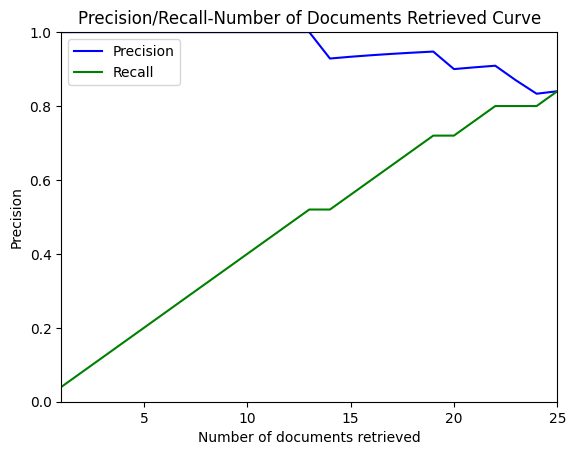

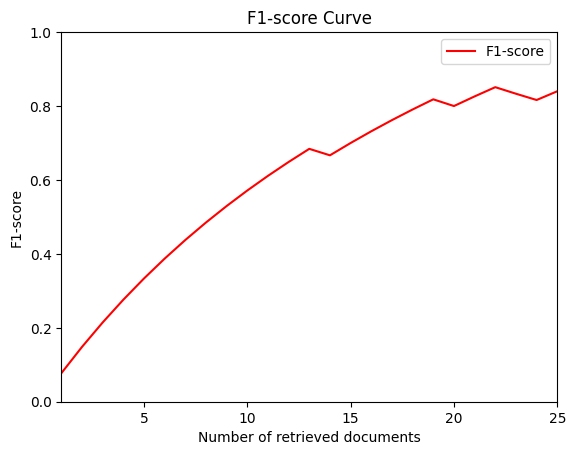

In [8]:
# Plotting Precision, Recall and F1 score curves
retrieved_docs_list = []
retrieved_docs_list.append(retrieved_results)
relevant_docs_list = [list(range(0,25))]

generate_mix(retrieved_docs_list, relevant_docs_list)
generate_f1_score_curve(retrieved_docs_list, relevant_docs_list)

# generate_precision_recall_curve(retrieved_docs_list, relevant_docs_list)
# generate_recall_curve(retrieved_docs_list, relevant_docs_list)


Boolean Retrieval

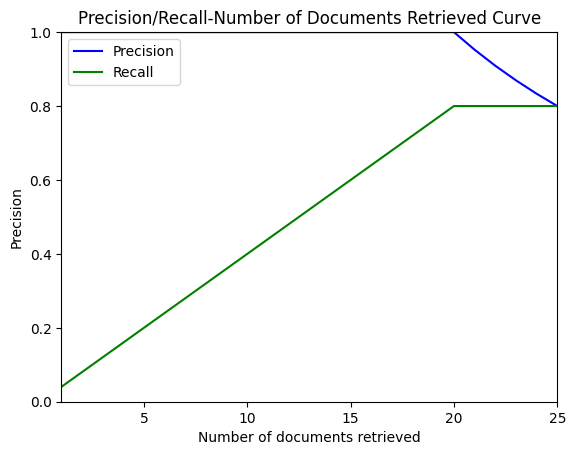

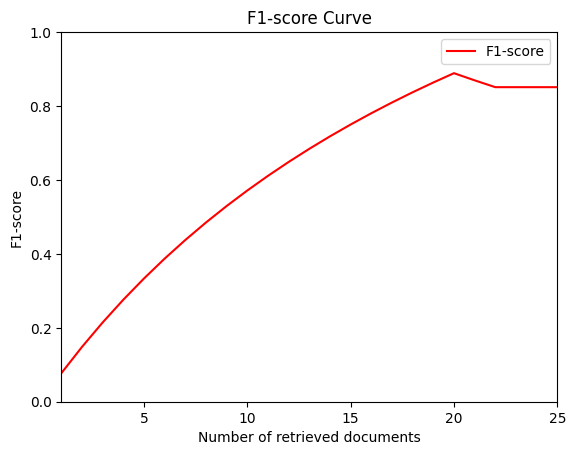

In [9]:
retrieved_docs_list = []
retrieved_docs_list.append(boolean_results)
relevant_docs_list = [list(range(0,25))]
generate_mix(retrieved_docs_list, relevant_docs_list)
generate_f1_score_curve(retrieved_docs_list, relevant_docs_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_precision_at_k(retrieved_docs, relevant_docs, k):
    num_retrieved = len(retrieved_docs[:k])
    num_relevant = len(relevant_docs)

    # Compute the number of retrieved relevant documents
    num_retrieved_relevant = len(set(retrieved_docs[:k]).intersection(set(relevant_docs)))

    # Compute the precision score at k
    precision = num_retrieved_relevant / k if k > 0 else 0

    return precision

def generate_precision_recall_curve(retrieved_docs_list, relevant_docs_list):
    num_queries = len(retrieved_docs_list)

    # Compute the precision scores for each query at different values of k
    k_values = np.arange(1, 11) # Consider top 1 to 10 retrieved documents
    precision_scores = np.zeros((num_queries, len(k_values)))
    for i in range(num_queries):
        for j, k in enumerate(k_values):
            precision = evaluate_precision_at_k(retrieved_docs_list[i], relevant_docs_list[i], k)
            precision_scores[i, j] = precision

    # Compute the mean precision scores across queries at each value of k
    mean_precision_scores = np.mean(precision_scores, axis=0)

    # Generate the precision-recall curve
    plt.plot(k_values, mean_precision_scores, 'b-', label='Precision')
    plt.xlabel('Number of documents retrieved')
    plt.ylabel('Precision')
    plt.title('Precision-Number of Documents Retrieved Curve')
    plt.ylim([0, 1])
    plt.xlim([1, 10])
    plt.legend(loc='best')
    plt.show()

In [ ]:


def evaluate_recall_at_k(retrieved_docs, relevant_docs, k):
    num_retrieved = len(retrieved_docs[:k])
    num_relevant = len(relevant_docs)

    # Compute the number of retrieved relevant documents
    num_retrieved_relevant = len(set(retrieved_docs[:k]).intersection(set(relevant_docs)))

    # Compute the recall score at k
    recall = num_retrieved_relevant / num_relevant if num_relevant > 0 else 0

    return recall

def generate_recall_curve(retrieved_docs_list, relevant_docs_list):
    num_queries = len(retrieved_docs_list)

    # Compute the recall scores for each query at different values of k
    k_values = np.arange(1, 11) # Consider top 1 to 10 retrieved documents
    recall_scores = np.zeros((num_queries, len(k_values)))
    for i in range(num_queries):
        for j, k in enumerate(k_values):
            recall = evaluate_recall_at_k(retrieved_docs_list[i], relevant_docs_list[i], k)
            recall_scores[i, j] = recall

    # Compute the mean recall scores across queries at each value of k
    mean_recall_scores = np.mean(recall_scores, axis=0)

    # Generate the recall curve
    plt.plot(k_values, mean_recall_scores, 'g-', label='Recall')
    plt.xlabel('Number of retrieved documents')
    plt.ylabel('Recall')
    plt.title('Recall Curve')
    plt.ylim([0, 1])
    plt.xlim([1, 10])
    plt.legend(loc='best')
    plt.show()

